# Final model with just the selected parameters

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('subset_data.csv/part-00000-03fb537b-9382-4a5b-bac8-26d245ab88ab-c000.csv')

In [2]:
df.head()

,x005,x276,x056,x193,x171,x075,x275,x281,x236,x057,...,x059,x055,x076,x274,x239,x245,x287,x014,x003,y
0,8.0,0,0,0,0,0,NaN,0,0,NaN,...,0,0,0,0,NaN,1,NaN,0,NaN,706
1,4.0,0,0,0,0,22375,NaN,5206,0,NaN,...,8,0,0,0,NaN,0,1.0,0,3.0,558
2,96.0,0,2,0,0,3287,0.4814,0,0,NaN,...,3,0,1,1613,NaN,1,NaN,0,NaN,577
3,258.0,1,2,8,0,684,1.1153,0,-156,1.52,...,5,0,1,4796,14.0,1,2.0,1,14.0,526
4,34.0,1,0,1,1,2810,0.1430,0,710,0.62,...,7,0,0,186,29.5,1,NaN,0,25.0,496


In [3]:
features = df[df.columns.difference(['y'])]
target = df.y

# Train test split

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=12345)

In [5]:
y_train = pd.Series(np.array(y_train), index=X_train.index)
y_test = pd.Series(np.array(y_test), index=X_test.index)

# Median imputation

In [6]:
median_values = X_train.median()

In [7]:
imputed_X_train = X_train.fillna(median_values)
imputed_X_test = X_test.fillna(median_values)

# Min Max scaler

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(imputed_X_train)
X_train = pd.DataFrame(scaler.transform(imputed_X_train), columns=imputed_X_train.columns)
X_test = pd.DataFrame(scaler.transform(imputed_X_test), columns=imputed_X_test.columns)

# PCA based variable reduction

In [9]:
from sklearn.decomposition import PCA

pca = PCA(.99)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [10]:
sum(pca.explained_variance_ratio_)

0.9907960222977913

In [11]:
pca.components_.shape

(14, 30)

In [12]:
transformed_X_train = pca.transform(X_train)
transformed_X_test = pca.transform(X_test)

# Autoencoder based variable reduction

In [13]:
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.backend import clear_session
from keras import backend as K
from keras.losses import mse, mean_squared_error, binary_crossentropy

class DeepVAE(object):
    
    def __init__(self, inout_dim, encoded_dims, activation_functions, optimizer, 
                 batch_size, latent_dim=2, beta = -0.5):  

        
        assert len(encoded_dims) == len(activation_functions), "number of activation functions and encodeing layers are different"
        
        self.batch_size = batch_size
        self.latent_dim = latent_dim
                
        # Input placeholder
        inputs = Input(shape=(inout_dim,), name='features')        
                
        ## encoding in latent space and sampling
        for k in range(len(encoded_dims)):
            if k == 0:
                x = Dense(encoded_dims[k], 
                                activation=activation_functions[k], 
                                name='x'+str(k+1))(inputs)
            else:
                x = Dense(encoded_dims[k], 
                                activation=activation_functions[k], 
                                name='x'+str(k+1))(x)
                
        z_mean = Dense(latent_dim, name='z_mean')(x)
        z_log_var = Dense(latent_dim, name='z_log_var')(x)
                
        # use reparameterization trick to push the sampling out as input
        # note that "output_shape" isn't necessary with the TensorFlow backend
        z = Lambda(self.sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
            
        # instantiate encoder model
        self._encoder_model = Model(inputs, [z_mean, z_log_var, z], name='Encoder')
        #print(self._encoder_model.summary())

        ## build decoder model
        latent_inputs = Input(shape=(latent_dim,), name='z_sampling') # latent dims of deepest layer
        kk = 0
        for k in reversed(range(len(encoded_dims))):
            if kk == 0:
                x = Dense(encoded_dims[k], 
                          activation=activation_functions[k],
                          name='x'+str(kk+1))(latent_inputs)
            else:    
                x = Dense(encoded_dims[k],
                          activation=activation_functions[k],
                          name='x'+str(kk+1))(x)
            kk += 1
        
        outputs = None
        if kk > 0:
            outputs = Dense(inout_dim, activation='linear', name='decoded_features')(x)
        else:
            outputs = Dense(inout_dim, activation='linear', name='decoded_features')(latent_inputs)
        
        # instantiate decoder model
        self._decoder_model = Model(latent_inputs, outputs, name='decoder')
        #print(self._decoder_model.summary())

        # instantiate VAE model
        outputs = self._decoder_model(self._encoder_model(inputs)[2])
        self._vae_model = Model(inputs, outputs, name='vae_mlp')
        
        # if croos_entropy loss, add kl loss to vae loss
        reconstruction_loss = mse(inputs, outputs)        
        reconstruction_loss *= inout_dim
        kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
        kl_loss = K.sum(kl_loss, axis=-1)
        kl_loss *= beta
        vae_loss = K.mean(reconstruction_loss + kl_loss)
        self._vae_model.add_loss(vae_loss)
        self._vae_model.compile(optimizer=optimizer)
        #print(self._vae_model.summary())
        
    # reparameterization trick
    # instead of sampling from Q(z|X), sample epsilon = N(0,I)
    # z = z_mean + sqrt(var) * epsilon
    def sampling(self, args):
        """Reparameterization trick by sampling from an isotropic unit Gaussian.
        # Arguments
            args (tensor): mean and log of variance of Q(z|X)
        # Returns
            z (tensor): sampled latent vector
        """

        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        # by default, random_normal has mean = 0 and std = 1.0
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + K.exp(0.5 * z_log_var) * epsilon


    def train(self, input_train, input_test, epochs, verbose=0):    
        
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10)
        
        history = self._vae_model.fit(input_train, epochs = epochs,
                                    batch_size=self.batch_size,
                                    shuffle=True, verbose=verbose, 
                                    validation_data=(input_test, None), 
                                    callbacks=[es])
        return history
    
    
    def getEncodedData(self, data):
        encoded_image = self._encoder_model.predict(data)
        return encoded_image
    
    def getDecodedData(self, encoded_data):
        decoded_data = self._decoder_model.predict(encoded_data)
        return decoded_data

In [14]:
clear_session()

# Tensorflow implementation
autoencodertf = DeepVAE(inout_dim=X_train.shape[1], 
                            encoded_dims=[10], 
                            activation_functions=['relu']*1,
                            optimizer='rmsprop',
                            batch_size=30, 
                            latent_dim=2, beta = -0.0005
                           )
#print(autoencodertf._vae_model.summary())
print(autoencodertf._encoder_model.summary())
print(autoencodertf._decoder_model.summary())
history = autoencodertf.train(input_train=X_train, input_test=X_test, epochs=10, verbose=1)

Model: "Encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
features (InputLayer)           [(None, 30)]         0                                            
__________________________________________________________________________________________________
x1 (Dense)                      (None, 10)           310         features[0][0]                   
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            22          x1[0][0]                         
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            22          x1[0][0]                         
____________________________________________________________________________________________

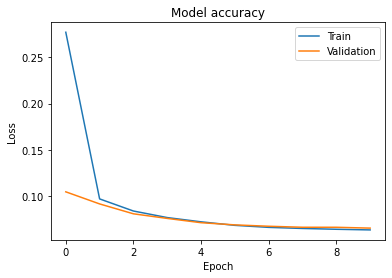

In [15]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [16]:
def r2(reco_data, act_data, size=1000):
   
    r_squared = 0
    k = 0
    for i in np.random.randint(0, reco_data.shape[0], size):  
        # for constant rows, stdev is 0 and so corrcoef is NaN
        if np.std(reco_data[i,:])==0 or np.std(act_data[i,:])==0:
            continue
        correlation_matrix = np.corrcoef(reco_data[i,:], act_data[i,:])
        correlation_xy = correlation_matrix[0,1]
        r_squared += correlation_xy**2
        #print(i, correlation_xy**2, np.std(reco_data[i,:]), np.std(act_data[i,:]))
        k += 1
   
    r_squared /= k
   
    return r_squared  

In [17]:
import numpy as np
encoded_data = autoencodertf.getEncodedData(X_train)
decoded_data = autoencodertf.getDecodedData(encoded_data)

print(np.mean(np.mean((decoded_data - X_train)**2, axis=1)))
print(r2(np.array(decoded_data), np.array(X_train)))

0.00186699080224419
0.9363372044145444


In [18]:
encoded_data = autoencodertf.getEncodedData(X_test)
decoded_data = autoencodertf.getDecodedData(encoded_data)

print(np.mean(np.mean((decoded_data - X_test)**2, axis=1)))
print(r2(np.array(decoded_data), np.array(X_test)))

0.0019167756484509007
0.9375053102406719


I wanted to showcase the VAE technique. I will continue using PCA output for further exploration.

# Model Evaluation metrics helper functions

In [19]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt 

# define model evaluation rmse function
def rmse(y, pred):
    rmse = sqrt(mean_squared_error(y, pred))
    return rmse

# define accuracy evaluation function
def accuracy(y, pred):
    accuracy = (np.abs(y - pred) <= 3.0).astype(int)
    return np.sum(accuracy)/len(accuracy)

# define model fit function
def model_fit(reg, X_train, X_test, y_train, y_test):
    
    reg.fit(X_train, y_train.ravel())

    #prediction results
    pred_train = reg.predict(X_train)
    pred_test = reg.predict(X_test)    
    pred_train = pred_train.ravel()
    pred_test = pred_test.ravel()
    pred_train[pred_train > 850] = 850
    pred_test[pred_test > 850] = 850
    pred_train[pred_train < 300] = 300
    pred_test[pred_test < 300] = 300
        
    temp_y_train = y_train.ravel()
    temp_y_test = y_test.ravel()
    
    rmse_train = rmse(temp_y_train, pred_train)
    rmse_test = rmse(temp_y_test, pred_test)
    acc_train = accuracy(temp_y_train, pred_train)
    acc_test = accuracy(temp_y_test, pred_test)
    r2_train = r2_score(temp_y_train, pred_train)
    r2_test = r2_score(temp_y_test, pred_test)
    
    print("\n")
    print("Train RMSE - ", rmse_train)
    print("Test RMSE - ", rmse_test)
    print("\n")
    print("Train Accuracy - ", acc_train)
    print("Test Accuracy - ", acc_test)
    print("\n")
    print("Train R squared - ", r2_train)
    print("Test R squared - ", r2_test)

    return rmse_train, rmse_test, acc_train, acc_test, r2_train, r2_test

In [26]:
import seaborn as sns

def make_confusion_matrix_chart(cf_matrix_train, cf_matrix_test):
    
    list_values = ['550 & Below', '550 - 649', '650-699', '700-749', '750 & Above']
    plt.figure(1, figsize=(10,5))

    plt.subplot(121)
    sns.heatmap(cf_matrix_train, annot=True, yticklabels=list_values, 
                                xticklabels=list_values, fmt='g')
    plt.ylabel("Actual")
    plt.xlabel("Pred")
    plt.ylim([0,len(list_values)])
    plt.title('Train data')

    plt.subplot(122)
    sns.heatmap(cf_matrix_test, annot=True, yticklabels=list_values, 
                                xticklabels=list_values, fmt='g')
    plt.ylabel("Actual")
    plt.xlabel("Pred")
    plt.ylim([0,len(list_values)])
    plt.tight_layout()
    plt.title('Test data')

    plt.tight_layout()
    return None

In [21]:
class_y_train = pd.DataFrame(y_train)[0].apply(lambda x: 0 if x <= 550 
                                            else 1 if x <=649 
                                            else 2 if x <=699
                                            else 3 if x <=749
                                           else 4)

class_y_test = pd.DataFrame(y_test)[0].apply(lambda x: 0 if x <= 550 
                                            else 1 if x <=649 
                                            else 2 if x <=699
                                            else 3 if x <=749
                                           else 4)

In [22]:
sample_X = X_train.sample(frac=0.15, random_state=123)
sample_y = class_y_train[class_y_train.index[sample_X.index]]

In [23]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(X_train, class_y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [24]:
from sklearn.metrics import accuracy_score, roc_curve, auc, classification_report, confusion_matrix

cf_matrix_train = confusion_matrix(class_y_train, clf.predict(X_train))
cf_matrix_test = confusion_matrix(class_y_test, clf.predict(X_test))

0.9999285714285714 0.7950666666666667


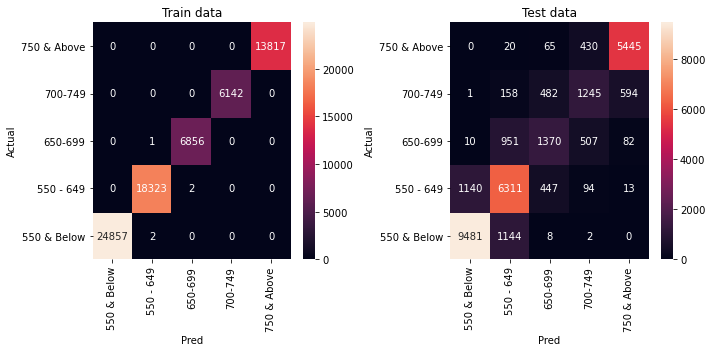

In [27]:
print(accuracy_score(class_y_train, clf.predict(X_train)), accuracy_score(class_y_test, clf.predict(X_test)))
make_confusion_matrix_chart(cf_matrix_train, cf_matrix_test)

In [ ]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

def hyperopt_train_test(params):
    clf = RandomForestClassifier(**params)
    return cross_val_score(clf, sample_X, sample_y).mean()

space4rf = {
    'max_depth': hp.choice('max_depth', range(1,20)),
    'max_features': hp.choice('max_features', range(1,5)),
    'n_estimators': hp.choice('n_estimators', range(1,200)),
    'criterion': hp.choice('criterion', ["gini", "entropy"])
}
best = 0
def f(params):
    global best
    acc = hyperopt_train_test(params)
    if acc > best:
        best = acc
    print('new best:', best, params)
    return {'loss': -acc, 'status': STATUS_OK}
trials = Trials()
best = fmin(f, space4rf, algo=tpe.suggest, max_evals=300, trials=trials)
print ('best:', best)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

reg_randomforest = RandomForestRegressor()

In [ ]:
rmse_train, rmse_test, acc_train, acc_test, r2_train, r2_test = model_fit(reg_randomforest, 
                                                                          X_train, 
                                                                          X_test,
                                                                          y_train,
                                                                          y_test)

In [ ]:
import keras.backend as K
import tensorflow as tf

def root_mean_squared_error(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

# define the model
def larger_model():
    # create model
    model = Sequential()
    model.add(Dense(30, input_dim=30, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(rate = 0.3))
    model.add(Dense(20, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(rate = 0.3))
    model.add(Dense(10, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(rate = 0.3))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss=root_mean_squared_error, optimizer='rmsprop')
    return model

# evaluate model with standardized dataset
estimators = []
#estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=larger_model, epochs=30, batch_size=16, verbose=1)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=5)
results = cross_val_score(pipeline, X_train, y_train, cv=kfold)
print("Larger: %.2f (%.2f) MSE" % (results.mean(), results.std()))